# Text translation using transformer architectures
 
Based on Tensorflow tutorial [Neural machine translation with a Transformer and Keras](https://www.tensorflow.org/text/tutorials/transformer)

Transformer model similar to that described in  [Attention is all you need](https://arxiv.org/abs/1706.03762)

- primary difference with model in seq2seq notebook is replacing the RNN layers with [self-attention](https://developers.google.com/machine-learning/glossary#self-attention) layers
- self-attention allows broader transmission of information across input sequences

1. prepare data
2. implement components
    1. positional embeddings
    1. attention layers
    1. encoder / decoder
1. build/train transformer
2. generate translations
3. export the model 

With modifications described along the way...this does not currently leverage any available GPU, but will by the time we're done...

## Step 0 - Environment Setup 

assumes tensorflow-text and tensorflow-datasets are installed in the environment
conda yaml for the environment compatible with all of these notebooks is included in the root of this repo 

In [2]:
import logging
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf

import tensorflow_text

In [3]:
local_data_path_root = "C:/LocalResearch/JPD-Research/translationWork"
local_data_path = local_data_path_root+ "/data"
local_vocab_path = local_data_path_root+ "/vocab/"
local_model_path = local_data_path_root+ "/models/"

# Directory where the checkpoints will be saved
checkpoint_dir = local_data_path_root + '/training_checkpoints'

## Step 1 - prepare the data

- get the data
- setup the tokenizer
- setup a pipeline using tf.data
- test the resulting dataset

### get the data
this reloads the dataset that was used in the subword tokenizer notebook

In [8]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en',
                               data_dir=local_data_path,
                               with_info=True,
                               as_supervised=True)

train_examples, val_examples = examples['train'], examples['validation']

In [9]:
for pt_examples, en_examples in train_examples.batch(3).take(1):
  print('> Examples in Portuguese:')
  for pt in pt_examples.numpy():
    print(pt.decode('utf-8'))
  print()

  print('> Examples in English:')
  for en in en_examples.numpy():
    print(en.decode('utf-8'))

> Examples in Portuguese:
e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .
mas e se estes fatores fossem ativos ?
mas eles não tinham a curiosidade de me testar .

> Examples in English:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


### setup the tokenizer
this loads the tokenizer created in the subword tokenizer notebook

In [10]:
model_name = 'ted_hrlr_translate_pt_en_converter'
tf.keras.utils.get_file(
    f'{model_name}.zip',
    f'https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip',
    cache_dir=local_model_path, cache_subdir='', extract=True
)

'C:/LocalResearch/JPD-Research/translationWork/models/ted_hrlr_translate_pt_en_converter.zip'

In [11]:
tokenizers = tf.saved_model.load(local_model_path+model_name)

In [12]:
[item for item in dir(tokenizers.en) if not item.startswith('_')]

['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

In [13]:
print('> This is a batch of strings:')
for en in en_examples.numpy():
  print(en.decode('utf-8'))

> This is a batch of strings:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


In [14]:
encoded = tokenizers.en.tokenize(en_examples)

print('> This is a padded-batch of token IDs:')
for row in encoded.to_list():
  print(row)

> This is a padded-batch of token IDs:
[2, 72, 117, 79, 1259, 1491, 2362, 13, 79, 150, 184, 311, 71, 103, 2308, 74, 2679, 13, 148, 80, 55, 4840, 1434, 2423, 540, 15, 3]
[2, 87, 90, 107, 76, 129, 1852, 30, 3]
[2, 87, 83, 149, 50, 9, 56, 664, 85, 2512, 15, 3]


In [15]:
round_trip = tokenizers.en.detokenize(encoded)

print('> This is human-readable text:')
for line in round_trip.numpy():
  print(line.decode('utf-8'))

> This is human-readable text:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n ' t test for curiosity .


In [16]:
print('> This is the text split into tokens:')
tokens = tokenizers.en.lookup(encoded)
tokens

> This is the text split into tokens:


<tf.RaggedTensor [[b'[START]', b'and', b'when', b'you', b'improve', b'search', b'##ability',
  b',', b'you', b'actually', b'take', b'away', b'the', b'one', b'advantage',
  b'of', b'print', b',', b'which', b'is', b's', b'##ere', b'##nd', b'##ip',
  b'##ity', b'.', b'[END]']                                                 ,
 [b'[START]', b'but', b'what', b'if', b'it', b'were', b'active', b'?',
  b'[END]']                                                           ,
 [b'[START]', b'but', b'they', b'did', b'n', b"'", b't', b'test', b'for',
  b'curiosity', b'.', b'[END]']                                          ]>

In [17]:
lengths = []

for pt_examples, en_examples in train_examples.batch(1024):
  pt_tokens = tokenizers.pt.tokenize(pt_examples)
  lengths.append(pt_tokens.row_lengths())

  en_tokens = tokenizers.en.tokenize(en_examples)
  lengths.append(en_tokens.row_lengths())
  print('.', end='', flush=True)

...................................................

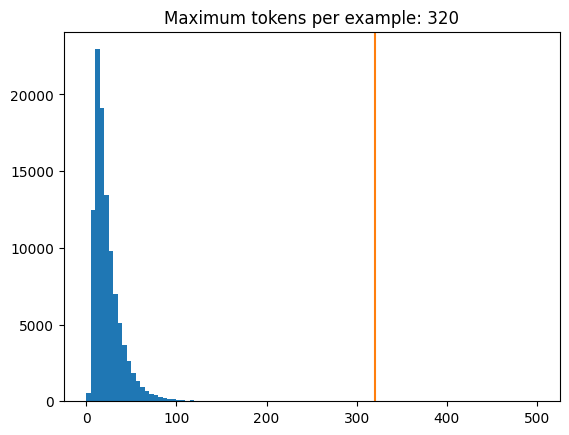

In [18]:
all_lengths = np.concatenate(lengths)

plt.hist(all_lengths, np.linspace(0, 500, 101))
plt.ylim(plt.ylim())
max_length = max(all_lengths)
plt.plot([max_length, max_length], plt.ylim())
plt.title(f'Maximum tokens per example: {max_length}');

### setup the data pipeline

1. tokenizes into ragged batches
2. trims each to MAX_TOKENS batches
3. splits target into inputs and labels - shifted by one so that each input label is the id of the next token
4. converts ragged tensors to padded dense tensors
5. returns (inputs, labels) pairs

In [24]:
MAX_TOKENS=128
def prepare_batch(pt, en):
    pt = tokenizers.pt.tokenize(pt)      # Output is ragged.
    pt = pt[:, :MAX_TOKENS]    # Trim to MAX_TOKENS.
    pt = pt.to_tensor()  # Convert to 0-padded dense Tensor

    en = tokenizers.en.tokenize(en)
    en = en[:, :(MAX_TOKENS+1)]
    en_inputs = en[:, :-1].to_tensor()  # Drop the [END] tokens
    en_labels = en[:, 1:].to_tensor()   # Drop the [START] tokens

    return (pt, en_inputs), en_labels

make_batches() converts text examples into batches for training (as described above)
1. tokenizes and filters (as batches for efficiency)
2. cache method to run once
3. shuffle / dense_to_ragged_batch randomize / assemble batches
4. prefetch runs in parallel with model

In [25]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [26]:
def make_batches(ds):
  return (
      ds
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(prepare_batch, tf.data.AUTOTUNE)
      .prefetch(buffer_size=tf.data.AUTOTUNE))

### test the dataset

In [30]:
# Create training and validation set batches.
train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

In [31]:
for (pt, en), en_labels in train_batches.take(1):
  break

print(pt.shape)
print(en.shape)
print(en_labels.shape)

(64, 80)
(64, 71)
(64, 71)


In [32]:
print(en[0][:10])
print(en_labels[0][:10])

tf.Tensor([   2   72   76   84   71 1616   74   71  377  143], shape=(10,), dtype=int64)
tf.Tensor([  72   76   84   71 1616   74   71  377  143   15], shape=(10,), dtype=int64)


## Step 2 - Implement components
- follows a similar architectural pattern to the sequence-to-sequence model
- makes sense a step at a time :)
### the embedding and positional encoding layer
- same logic in encoder and decoder
- uses set of sines/cosines at different frequencies - nearby elements will have similar position encodings 

In [39]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1) 

  return tf.cast(pos_encoding, dtype=tf.float32)

(2048, 512)


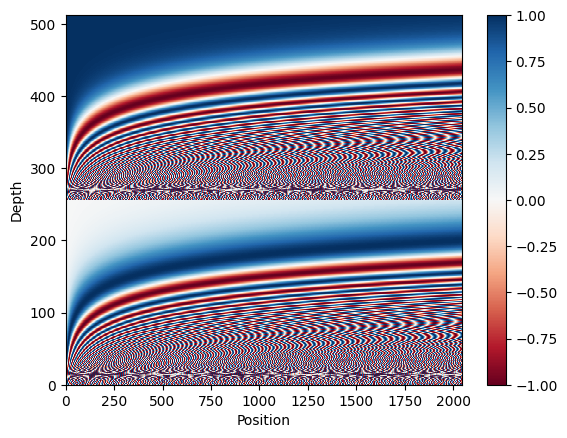

In [40]:
pos_encoding = positional_encoding(length=2048, depth=512)

# Check the shape.
print(pos_encoding.shape)

# Plot the dimensions.
plt.pcolormesh(pos_encoding.numpy().T, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

(0.0, 1.0)

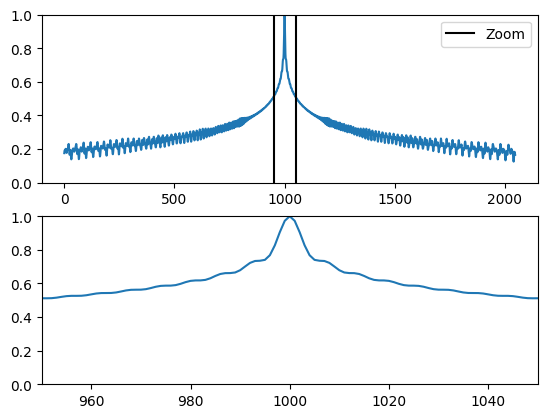

In [41]:
pos_encoding/=tf.norm(pos_encoding, axis=1, keepdims=True)
p = pos_encoding[1000]
dots = tf.einsum('pd,d -> p', pos_encoding, p)
plt.subplot(2,1,1)
plt.plot(dots)
plt.ylim([0,1])
plt.plot([950, 950, float('nan'), 1050, 1050],
         [0,1,float('nan'),0,1], color='k', label='Zoom')
plt.legend()
plt.subplot(2,1,2)
plt.plot(dots)
plt.xlim([950, 1050])
plt.ylim([0,1])

In [43]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True) 
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

In [44]:
embed_pt = PositionalEmbedding(vocab_size=tokenizers.pt.get_vocab_size(), d_model=512)
embed_en = PositionalEmbedding(vocab_size=tokenizers.en.get_vocab_size(), d_model=512)

pt_emb = embed_pt(pt)
en_emb = embed_en(en)

In [45]:
en_emb._keras_mask

<tf.Tensor: shape=(64, 71), dtype=bool, numpy=
array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])>

### add and normalize block

these exist throughout the model - each joins a residual connection and runs the result through a LayerNormalization layer
- residual Add/Norm blocks make training efficient
- residual connection provides path for gradient (UPDATES from attention layer rather than REPLACED)
- normalization maintains reasonable scale

### base attention layer
these also exist throughout the model - all are identical except for attention configuration
- each one contains a MultiHeadAttention, LayerNormalization and Add (see above)
- in this code, base class (BaseAttention) contains the component layers, and each use case is implemented as a subclass
    - more code but clearer 

In [46]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

- attention refresher
    - two inputs
        - query sequence (bottom): sequence being processed, sequence doing the attending
        - context sequence (left): sequence being attended to
    - output has same shape as query sequence
    - like a fuzzy, differentiable, vectorized dictionary lookup
  

In [49]:
# regular python dictionary
d = {'color': 'blue', 'age': 22, 'type': 'pickup'}
result = d['color']
print(result)
print(d['age'])

blue
22


- the query is what you're looking for
- the key contains the kind of information the dictionary has
- the value is the information contained
    
- for a normal dictionary, the query finds the matching key and returns the associated value
    - query either has a matching key or not
    - for a fuzzy dictionary, key may not match perfectly - above d['species'] might return d['type'] since that's the closest match
- attention layer doesn't (just) look for the best key
    - combines available values based on how well query matches the keys
            - 'attention score' - combination of query and key vectors determined by how well they match
            - returns average across ALL values, weighted by 'attention score'
- each location in the query sequence provides a query vector
- context sequence acts as the dictionary
    - input vectors not used directly - MultiHeadAttention includes Dense layers that project the input vectors before using them

### cross attention layer  
- this connects the encoder and the decoder
- simplest use - same purpose as in the seq2seq notebook
    - pass in the target sequence 'x' as teh query and the context as the key/value when calling MHA 
    - note
        - output is the length of the query sequence, not length of the key/value sequence
        - weight "matrix" is less important, point is that each query location can see ALL key/value pairs in the context, but the queries share no information  

In [51]:
class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        return_attention_scores=True)

    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [52]:
sample_ca = CrossAttention(num_heads=2, key_dim=512)

print(pt_emb.shape)
print(en_emb.shape)
print(sample_ca(en_emb, pt_emb).shape)

(64, 80, 512)
(64, 71, 512)
(64, 71, 512)


### global self-attention layer

- processes the context sequence - fixed during translation - and propagating info along its length
- info flows in both directions
- before self-attention, RNNs/CNNs were used for this
    - RNN allows info to flow across the sequence, but many steps taken to get there (limiting gradient flow)
        - RNN steps run sequentially, less able to leverage parallel hardware
    - CNN could be processed in parallel, but provides a limited receptive field
        - field grows linearly with number of CNN layers - requires a stack to transmit across the sequence
- global self-attention allows every sequence element to directly access any other sequence element with only a few parallelizable operations
- to implement, pas target sequence as query and value args to the mha layer   

In [54]:
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [55]:
sample_gsa = GlobalSelfAttention(num_heads=2, key_dim=512)

print(pt_emb.shape)
print(sample_gsa(pt_emb).shape)

(64, 80, 512)
(64, 80, 512)


### causal self-attention layer

- similar job as the encoder's global self-attention layer, but for the output sequence, but needs different treatment
- transformers are "auto-regressive" - generate text one token at a time and feed the output back to the input
- for efficiency, "causal" models ensure that outputs for each sequence element depend only on previous sequence elements
    - single-direction RNNs are causal by definition
    - for a causal convolution, you need to pad the input and shift output so it aligns correctly
    - in training, you can compute loss for each location in the output sequence by executing the model once
    - during inference, for every new generated token you only need to calculate its output - prev output sequence elements can be reused
        - for an RNN - just need RNN state to account for previous computations
        - for a CNN - need to follow "Fast Wavenet" approach   
                
- for calculation, need to mask when computing attention scores and summing attention values as in the following code:

In [56]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [57]:
sample_csa = CausalSelfAttention(num_heads=2, key_dim=512)

print(en_emb.shape)
print(sample_csa(en_emb).shape)

(64, 71, 512)
(64, 71, 512)


In [58]:
out1 = sample_csa(embed_en(en[:, :3])) 
out2 = sample_csa(embed_en(en))[:, :3]

tf.reduce_max(abs(out1 - out2)).numpy()

4.7683716e-07

### the feed-forward network

Point-wise feed-forward networks occur oin the encoder and decoder, consisting of:
- two linear layers
- ReLU activation in-between
- and a dropout layer
    - a layer used to prevent overfitting by statistically removing some nodes during training as described [here](https://databasecamp.de/en/ml/dropout-layer-en#:~:text=The%20dropout%20layer%20is%20a,the%20network%20architecture%20at%20all.)

In [59]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x) 
    return x

In [60]:
sample_ffn = FeedForward(512, 2048)

print(en_emb.shape)
print(sample_ffn(en_emb).shape)

(64, 71, 512)
(64, 71, 512)


### the encoder layer

- encoder is a stack of N encoder layers, each consists of a GlobalSelfAttention and FeedForward layer

In [61]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

In [62]:
sample_encoder_layer = EncoderLayer(d_model=512, num_heads=8, dff=2048)

print(pt_emb.shape)
print(sample_encoder_layer(pt_emb).shape)

(64, 80, 512)
(64, 80, 512)


### building the encoder

- consists of a PositionalEmbedding layer at the input
- and a stack of EncoderLayer layers

In [65]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

    # Add dropout.
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x  # Shape `(batch_size, seq_len, d_model)`.

In [66]:
# Instantiate the encoder.
sample_encoder = Encoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=8500)

sample_encoder_output = sample_encoder(pt, training=False)

# Print the shape.
print(pt.shape)
print(sample_encoder_output.shape)  # Shape `(batch_size, input_seq_len, d_model)`.

(64, 80)
(64, 80, 512)


### the decoder layer

- slightly more involved, with each DecoderLayer containing a CausalSelfAttention, CrossAttention and FeedForward layers

In [67]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)

    # Cache the last attention scores for plotting later
    self.last_attn_scores = self.cross_attention.last_attn_scores

    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
    return x

In [68]:
sample_decoder_layer = DecoderLayer(d_model=512, num_heads=8, dff=2048)

sample_decoder_layer_output = sample_decoder_layer(
    x=en_emb, context=pt_emb)

print(en_emb.shape)
print(pt_emb.shape)
print(sample_decoder_layer_output.shape)  # `(batch_size, seq_len, d_model)`

(64, 71, 512)
(64, 80, 512)
(64, 71, 512)


### the decoder
consists of a PositionalEmbedding and a stack of DecoderLayer objects

In [69]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                             d_model=d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    self.last_attn_scores = None

  def call(self, x, context):
    # `x` is token-IDs shape (batch, target_seq_len)
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

    x = self.dropout(x)

    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)

    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    # The shape of x is (batch_size, target_seq_len, d_model).
    return x

In [70]:
# Instantiate the decoder.
sample_decoder = Decoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=8000)

output = sample_decoder(
    x=en,
    context=pt_emb)

# Print the shapes.
print(en.shape)
print(pt_emb.shape)
print(output.shape)

(64, 71)
(64, 80, 512)
(64, 71, 512)


In [71]:
sample_decoder.last_attn_scores.shape  # (batch, heads, target_seq, input_seq)

TensorShape([64, 8, 71, 80])

## Step 3 - Building the Transformer

- need to connect the encoder and decoder
- also need to add a linear layer converting the output vector at each location into output token probabilities
- Transformer with 1 layer encoder/decoder looks like the RNN example model
    - multi-layer Transformers has more layers but does effectively the same thing  

In [72]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs):
    # To use a Keras model with `.fit` you must pass all your inputs in the
    # first argument.
    context, x  = inputs

    context = self.encoder(context)  # (batch_size, context_len, d_model)

    x = self.decoder(x, context)  # (batch_size, target_len, d_model)

    # Final linear layer output.
    logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

    try:
      # Drop the keras mask, so it doesn't scale the losses/metrics.
      # b/250038731
      del logits._keras_mask
    except AttributeError:
      pass

    # Return the final output and the attention weights.
    return logits

### hyperparameters

- base model in Transformers paper had 6 layers, with d_model=512 and dff=2048
- this model uses 4 layers, with d_model=128 and dff=512
- number of heads (8) is same in both

In [73]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

In [74]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.pt.get_vocab_size().numpy(),
    target_vocab_size=tokenizers.en.get_vocab_size().numpy(),
    dropout_rate=dropout_rate)

In [75]:
output = transformer((pt, en))

print(en.shape)
print(pt.shape)
print(output.shape)

(64, 71)
(64, 80)
(64, 71, 7010)


In [76]:
attn_scores = transformer.decoder.dec_layers[-1].last_attn_scores
print(attn_scores.shape)  # (batch, heads, target_seq, input_seq)

(64, 8, 71, 80)


In [77]:
transformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (Encoder)         multiple                  3632768   
                                                                 
 decoder_1 (Decoder)         multiple                  5647104   
                                                                 
 dense_38 (Dense)            multiple                  904290    
                                                                 
Total params: 10,184,162
Trainable params: 10,184,162
Non-trainable params: 0
_________________________________________________________________


## Step 4 Training the Transformer

### set up the optimizer

- uses the Adam optimizer with a custom learning rate scheduler as in the formula from the original Transformer paper

In [78]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [79]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

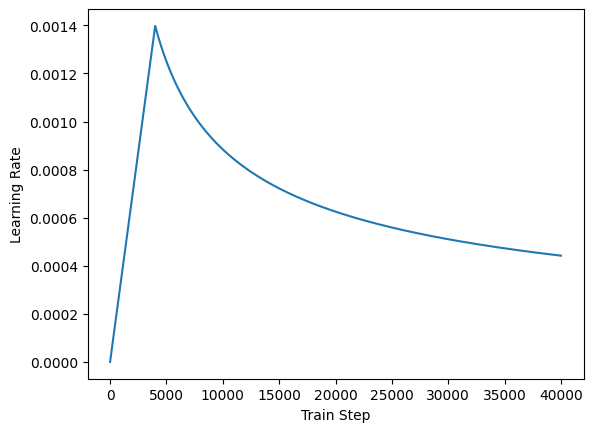

In [80]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

 ### set up the loss and metric
 
- need to use a padding mask when calculating loss - use crossEntropy loss function

In [81]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss


def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

### Training the model
- takes about an day on typical hardware :(

In [83]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

In [84]:
transformer.fit(train_batches,
                epochs=20,
                validation_data=val_batches)

Epoch 1/20
810/810 [==============================] - 3315s 4s/step - loss: 6.5887 - masked_accuracy: 0.1377 - val_loss: 5.0099 - val_masked_accuracy: 0.2535
Epoch 2/20
810/810 [==============================] - 3142s 4s/step - loss: 4.5565 - masked_accuracy: 0.3004 - val_loss: 4.0593 - val_masked_accuracy: 0.3607
Epoch 3/20
810/810 [==============================] - 3222s 4s/step - loss: 3.8241 - masked_accuracy: 0.3803 - val_loss: 3.4507 - val_masked_accuracy: 0.4323
Epoch 4/20
810/810 [==============================] - 3190s 4s/step - loss: 3.2942 - masked_accuracy: 0.4376 - val_loss: 3.0067 - val_masked_accuracy: 0.4869
Epoch 5/20
810/810 [==============================] - 3290s 4s/step - loss: 2.8997 - masked_accuracy: 0.4812 - val_loss: 2.7722 - val_masked_accuracy: 0.5147
Epoch 6/20
810/810 [==============================] - 3137s 4s/step - loss: 2.5819 - masked_accuracy: 0.5199 - val_loss: 2.5159 - val_masked_accuracy: 0.5453
Epoch 7/20
810/810 [==============================] 

## Step 5 Running inference

1. Encode input sentence using the Portuguese tokenizer - encoder input
2. Decoder input is initialized to the Start token
3. Calculate padding and look-ahead masks
4. decoder outputs predictions looking at encoder output and its own output
5. concatenate predicted token to the decoder input and pass to decoder
    - decoder predicts next token based on previously predicted tokens 

In [85]:
class Translator(tf.Module):
  def __init__(self, tokenizers, transformer):
    self.tokenizers = tokenizers
    self.transformer = transformer

  def __call__(self, sentence, max_length=MAX_TOKENS):
    # The input sentence is Portuguese, hence adding the `[START]` and `[END]` tokens.
    assert isinstance(sentence, tf.Tensor)
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]

    sentence = self.tokenizers.pt.tokenize(sentence).to_tensor()

    encoder_input = sentence

    # As the output language is English, initialize the output with the
    # English `[START]` token.
    start_end = self.tokenizers.en.tokenize([''])[0]
    start = start_end[0][tf.newaxis]
    end = start_end[1][tf.newaxis]

    # `tf.TensorArray` is required here (instead of a Python list), so that the
    # dynamic-loop can be traced by `tf.function`.
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      predictions = self.transformer([encoder_input, output], training=False)

      # Select the last token from the `seq_len` dimension.
      predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.

      predicted_id = tf.argmax(predictions, axis=-1)

      # Concatenate the `predicted_id` to the output which is given to the
      # decoder as its input.
      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())
    # The output shape is `(1, tokens)`.
    text = tokenizers.en.detokenize(output)[0]  # Shape: `()`.

    tokens = tokenizers.en.lookup(output)[0]

    # `tf.function` prevents us from using the attention_weights that were
    # calculated on the last iteration of the loop.
    # So, recalculate them outside the loop.
    self.transformer([encoder_input, output[:,:-1]], training=False)
    attention_weights = self.transformer.decoder.last_attn_scores

    return text, tokens, attention_weights

In [86]:
translator = Translator(tokenizers, transformer)

In [87]:
def print_translation(sentence, tokens, ground_truth):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
  print(f'{"Ground truth":15s}: {ground_truth}')

Example 1:

In [88]:
sentence = 'este é um problema que temos que resolver.'
ground_truth = 'this is a problem we have to solve .'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : este é um problema que temos que resolver.
Prediction     : this is a problem that we have to solve .
Ground truth   : this is a problem we have to solve .


Example 2:

In [89]:
sentence = 'os meus vizinhos ouviram sobre esta ideia.'
ground_truth = 'and my neighboring homes heard about this idea .'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : os meus vizinhos ouviram sobre esta ideia.
Prediction     : my neighbors heard about this idea .
Ground truth   : and my neighboring homes heard about this idea .


Example 3:

In [90]:
sentence = 'vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.'
ground_truth = "so i'll just share with you some stories very quickly of some magical things that have happened."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.
Prediction     : so i ' m going to share with you some magic stories that will occur .
Ground truth   : so i'll just share with you some stories very quickly of some magical things that have happened.


## Step 6 Creating attention plots


In [91]:
sentence = 'este é o primeiro livro que eu fiz.'
ground_truth = "this is the first book i've ever done."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : este é o primeiro livro que eu fiz.
Prediction     : this is the first book i made .
Ground truth   : this is the first book i've ever done.


In [92]:
def plot_attention_head(in_tokens, translated_tokens, attention):
  # The model didn't generate `<START>` in the output. Skip it.
  translated_tokens = translated_tokens[1:]

  ax = plt.gca()
  ax.matshow(attention)
  ax.set_xticks(range(len(in_tokens)))
  ax.set_yticks(range(len(translated_tokens)))

  labels = [label.decode('utf-8') for label in in_tokens.numpy()]
  ax.set_xticklabels(
      labels, rotation=90)

  labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
  ax.set_yticklabels(labels)

In [93]:
head = 0
# Shape: `(batch=1, num_heads, seq_len_q, seq_len_k)`.
attention_heads = tf.squeeze(attention_weights, 0)
attention = attention_heads[head]
attention.shape

TensorShape([9, 11])

for the input tokens (Portuguese):

In [94]:
in_tokens = tf.convert_to_tensor([sentence])
in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
in_tokens = tokenizers.pt.lookup(in_tokens)[0]
in_tokens

<tf.Tensor: shape=(11,), dtype=string, numpy=
array([b'[START]', b'este', b'e', b'o', b'primeiro', b'livro', b'que',
       b'eu', b'fiz', b'.', b'[END]'], dtype=object)>

for the output tokens (English translation):

In [95]:
translated_tokens

<tf.Tensor: shape=(10,), dtype=string, numpy=
array([b'[START]', b'this', b'is', b'the', b'first', b'book', b'i',
       b'made', b'.', b'[END]'], dtype=object)>

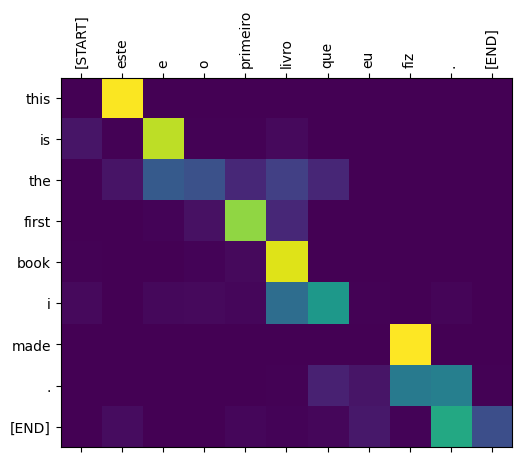

In [96]:
plot_attention_head(in_tokens, translated_tokens, attention)

In [97]:
def plot_attention_weights(sentence, translated_tokens, attention_heads):
  in_tokens = tf.convert_to_tensor([sentence])
  in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
  in_tokens = tokenizers.pt.lookup(in_tokens)[0]

  fig = plt.figure(figsize=(16, 8))

  for h, head in enumerate(attention_heads):
    ax = fig.add_subplot(2, 4, h+1)

    plot_attention_head(in_tokens, translated_tokens, head)

    ax.set_xlabel(f'Head {h+1}')

  plt.tight_layout()
  plt.show()

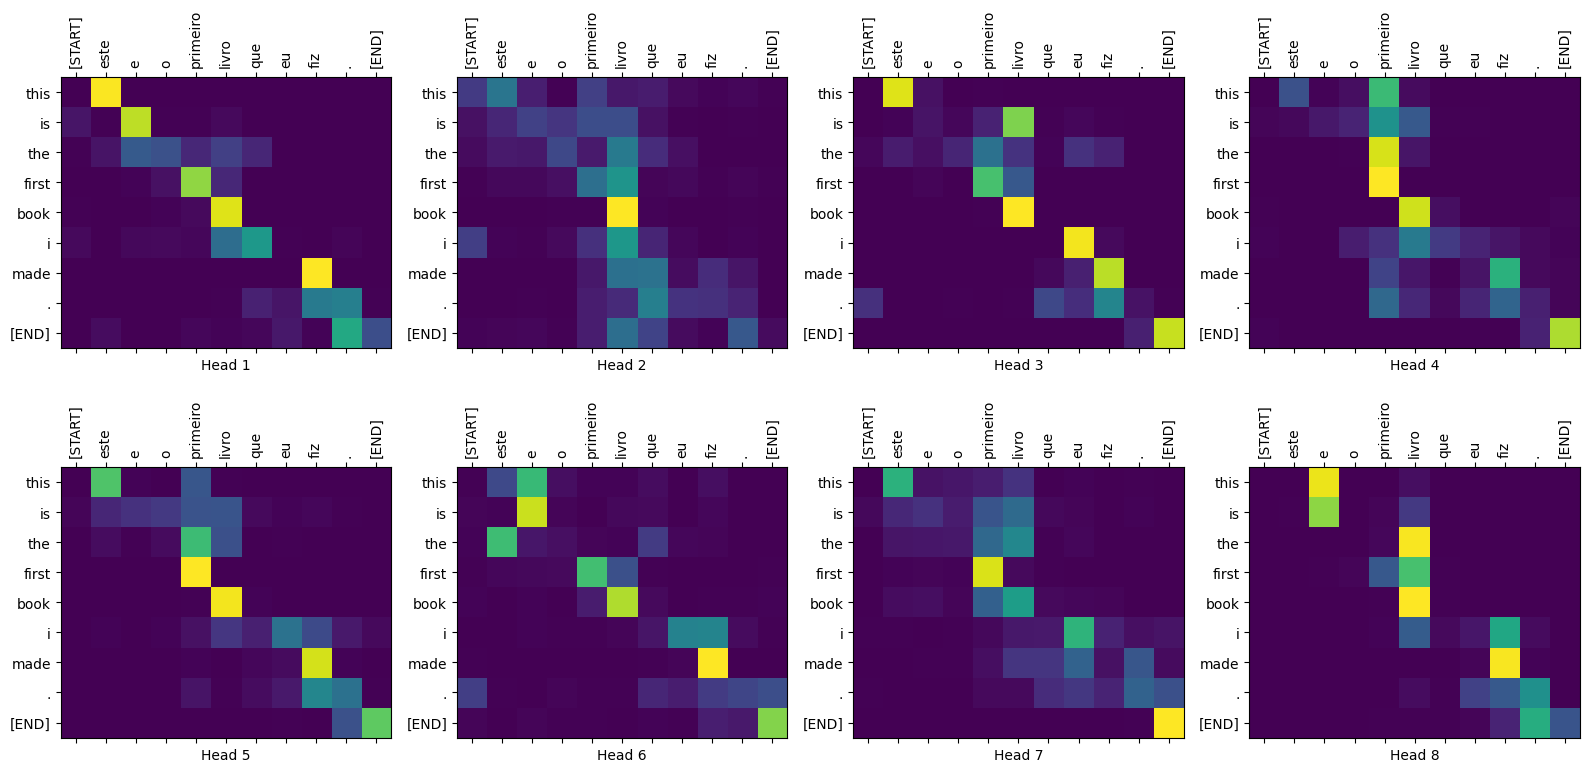

In [98]:
plot_attention_weights(sentence,
                       translated_tokens,
                       attention_weights[0])

Input:         : Eu li sobre triceratops na enciclopédia.
Prediction     : i read about chillers on encyclopedia .
Ground truth   : I read about triceratops in the encyclopedia.


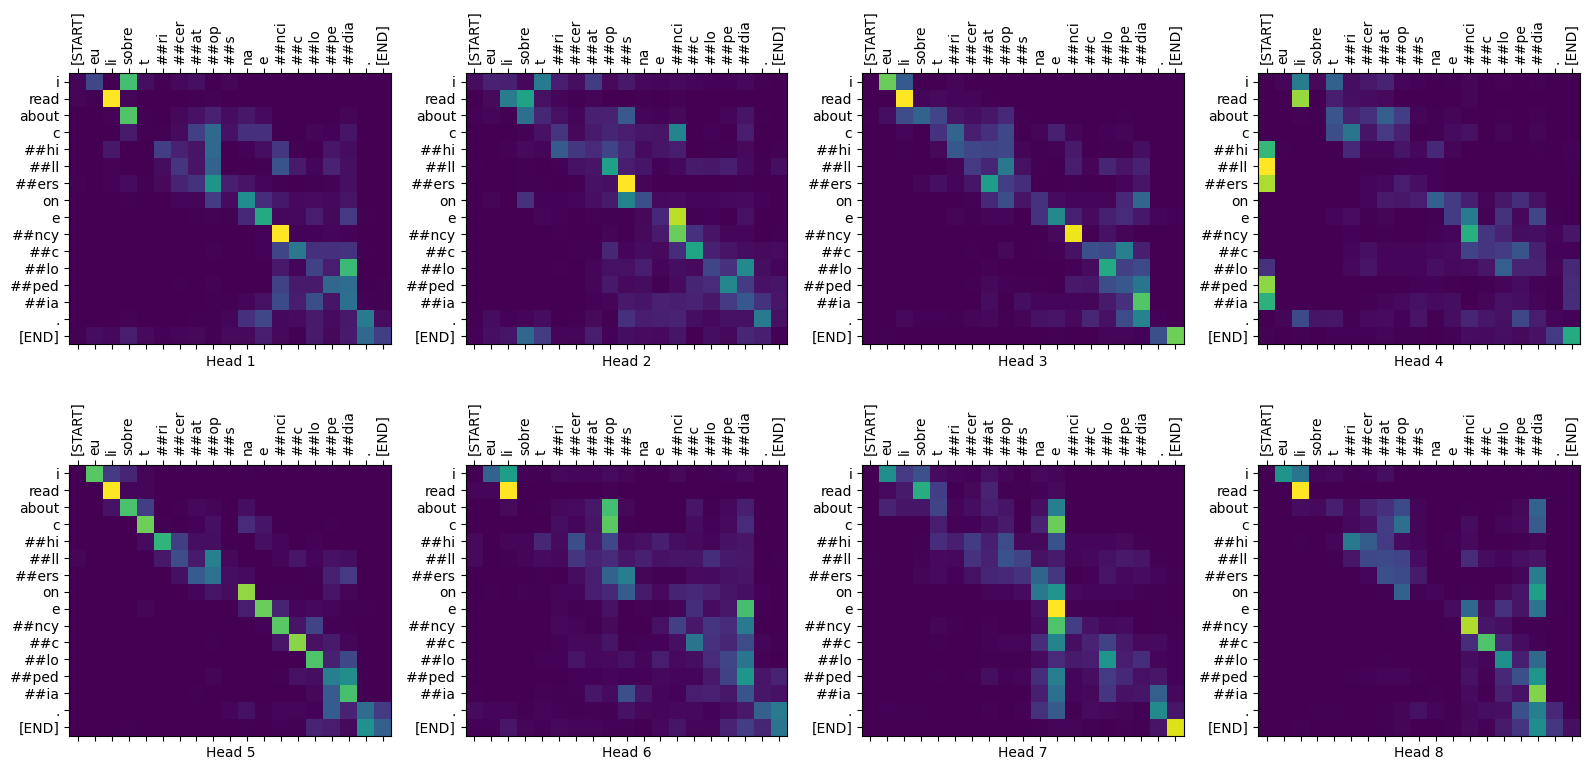

In [99]:
sentence = 'Eu li sobre triceratops na enciclopédia.'
ground_truth = 'I read about triceratops in the encyclopedia.'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

plot_attention_weights(sentence, translated_tokens, attention_weights[0])

## Step 7 Exporting the model

In [100]:
class ExportTranslator(tf.Module):
  def __init__(self, translator):
    self.translator = translator

  @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
  def __call__(self, sentence):
    (result,
     tokens,
     attention_weights) = self.translator(sentence, max_length=MAX_TOKENS)

    return result

In [101]:
translator = ExportTranslator(translator)

In [102]:
translator('este é o primeiro livro que eu fiz.').numpy()

b'this is the first book i made .'

In [103]:
tf.saved_model.save(translator, export_dir=local_model_path+'translator')

INFO:tensorflow:Assets written to: C:/LocalResearch/JPD-Research/translationWork/models/translator\assets


INFO:tensorflow:Assets written to: C:/LocalResearch/JPD-Research/translationWork/models/translator\assets


In [104]:
reloaded = tf.saved_model.load(local_model_path+'translator')

In [105]:
reloaded('este é o primeiro livro que eu fiz.').numpy()

b'this is the first book i made .'

## Step 8 - recap
This process covered:
- transformer architecture
- attention / self-attention / multi-head attention
- positional encodings and embeddings
- masking
- how to build a translator
Downsides
- for time series, each step calculated from entire history rather than only inputs and hidden state
- positional encoding required for inputs with temporal/spatial relationships (text / images) or the model will see a bag of words

## Step 9 - Still to do

- better understand
    - how to determine an optimal stack size for encoder/decoder
    - implement a BERT model
    - use "Beam search" to improve predictions (how does this differ from attention...)
    - how to apply transformers for vision or other non-text modalities
- enable GPU (local and on Rosie)     